# Bryan Examples

In [1]:
import random
import math
import sys
import os
import glob
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.silence import detect_silence, detect_nonsilent
from collections import defaultdict
from pydub.playback import play
from scipy.io import wavfile
from scipy import signal

In [25]:
BRYAN_LECTURES = "../raw_data/bryan_lectures/"
POSITIVE_DIRECTORY = "../raw_data/positive_data/right/"
AUDIO_IGNORED_EXAMPLES_DIRECTORY = "../audio_ignored_examples/"
TRAINING_SET_DIRECTORY = "../data/train_set/"

In [3]:
POSITIVE_AUDIONAMES = [name for name in os.listdir(POSITIVE_DIRECTORY) if name.endswith("wav")]    

## Process Lecture
Cut out long periods of silence

In [ ]:
def process_lecture(input_filepath, output_filepath, min_silence_len=3000, silence_thresh=-20, seek_step=3000):
    assert file_path.endswith('.mp4'), "Only processes mp4 videos!"
    
    # Import mp4
    segment = AudioSegment.from_file(input_filepath, "mp4")
    
    silent_ranges = detect_silence(segment, min_silence_len, silence_thresh, seek_step)
    print("Silent ranges in ms... {}".format(silent_ranges))
    
    # Trim silence
    # AudioSegments do not support `remove` functionality. Instead of removing silence, this code concatenates non-silence.
    # Internally its the same as `detect_nonsilence` uses `detect_silence` and takes the complement of the result.
    print("Concatenating nonsilent ranges...")
    nonsilent_ranges = detect_nonsilent(segment, min_silence_len, silence_thresh, seek_step) 
    result = AudioSegment.empty()
    for nonsilent_range in nonsilent_ranges:
        [start, end] = nonsilent_range
        result += segment[start: end]
        
    # Double check
    silent_ranges = detect_silence(result, min_silence_len, silence_thresh, seek_step)
    assert silent_ranges == [], "There are still silent ranges. Double check parameters of detect_nonsilent"
    
    # Set frame rate to 123000
    result = result.set_channels(1)
    result = result.set_frame_rate(123000)
    
    # Output as monochrome wav
    result.export(output_filepath, format='wav')
    print("Audio output in {}".format(output_filepath))

## Create One Training Example

In [4]:
Tx = 5490 # Based on created training example
n_freq = 129 # Based on created training example
Ty = 1369 # Based on model.summary() in 1.4 with shape := (Tx, n_freq)
min_silence_len = 1000
silence_thres = -20
seek_step = 1000
mini_segment_duration = 15000 # Allowing mini_segment_duration > labelled_duration is useful when substituting silence with filler words which are too short, which causes segment to be padded with too much silence at the end.
labelled_duration = 10000 

In [59]:
# input_filepath = BRYAN_LECTURES + "bayes_inference_processed.wav"
# segment = AudioSegment.from_wav(input_filepath)

In [60]:
def make_silence_dict(segment):
    """ Returns dictionary mapping number of silence in the %labelled_duration (ms) of mini_segment to mini_segment (ms). 
    """
    silence_dict = defaultdict(set)
    for mini_segment_start in range(0, len(segment) - mini_segment_duration, mini_segment_duration):
        mini_segment = segment[mini_segment_start: mini_segment_start + mini_segment_duration]
        silent_ranges = detect_silence(mini_segment[:labelled_duration], min_silence_len, silence_thres, seek_step)
        silence_dict[len(silent_ranges)].add(mini_segment)
    return silence_dict

In [12]:
# silence_dict = make_silence_dict(segment)
# for k in silence_dict.keys():
#     print("{} silence has {} examples".format(k, len(silence_dict[k])))
    
# silence_count = 2
# mini_segment = silence_dict[silence_count].pop() 
# silence_dict[silence_count].add(mini_segment) 
# silent_ranges = detect_silence(mini_segment[:labelled_duration], min_silence_len, silence_thres, seek_step)
# print(silent_ranges)
# assert len(silent_ranges) == silence_count, "Silence count does not match number of silence in segment.  Check construction of silence dict."

1 silence has 243 examples
2 silence has 99 examples
3 silence has 29 examples
0 silence has 105 examples
4 silence has 3 examples
[[1000, 3000], [9000, 10000]]


In [46]:
play(mini_segment)

In [14]:
def create_X(segment, output_filepath, save):
    file_handle = segment.export(output_filepath, format='wav')

    sample_rate, samples = wavfile.read(output_filepath)
    frequencies, times, x = signal.spectrogram(samples, sample_rate)
    
    if save: print("File was saved in {}".format(output_filepath))
    else: os.remove(output_filepath)
        
    return frequencies, times, x

In [15]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [16]:
def create_Y(inserted_points):
    # Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))
    
    for point in inserted_points:
        y = insert_ones(y, point)
        
    assert y.shape == (1, Ty), "y shape needs to follow Ty!"
    
    return y

In [17]:
def random_positive(positive_audionames, debug = False):
    """
    Given a list of random positive audio names
    Return a randomly selected positive segment
    """
    # generate a random audio
    random_positive = np.random.choice(positive_audionames, 1, replace=False)[0]
    if debug:
        print("Selecting positive file randomly:\n    - {}".format(random_positive))
    # load audio
    global POSITIVE_DIRECTORY
    link = POSITIVE_DIRECTORY + random_positive
    return AudioSegment.from_wav(link)

In [47]:
def sub_filler(segment, debug = False):
    """ Inserts filler in every >= 1s pause in segment
    """
    
    result = AudioSegment.empty()
    inserted_points = []
    
    # if there's silence at the start, add filler word there
    silent_ranges = detect_silence(segment, min_silence_len, silence_thres, seek_step)
    first_silence_start = silent_ranges[0][0]
    if first_silence_start == 0:
        if debug: print("Filler added at {} ms".format(result.duration_seconds * 1000))
        result = random_positive(POSITIVE_AUDIONAMES)
        inserted_points.append(result.duration_seconds * 1000)
    
    # adds filler word between nonsilent range
    nonsilent_ranges = detect_nonsilent(segment, min_silence_len, silence_thres, seek_step)
    for nonsilent_range in nonsilent_ranges: # adds filler after nonsilent ranges
        [start, end] = nonsilent_range
        result += segment[start:end]
        
        if nonsilent_range == nonsilent_ranges[-1]: continue # skip last
        if debug: print("Filler added at {} ms".format(result.duration_seconds * 1000))
        result += random_positive(POSITIVE_AUDIONAMES)
        inserted_points.append(result.duration_seconds * 1000)
    
    # if there's silence at the end, add filler word there
    last_silence_end = silent_ranges[-1][-1]
    if last_silence_end == segment.duration_seconds * 1000:
        if debug: print("Filler added at {} ms".format(result.duration_seconds * 1000))
        result += random_positive(POSITIVE_AUDIONAMES)
        inserted_points.append(result.duration_seconds * 1000)
    
    return result, inserted_points

In [255]:
# # Larry's filler word
# larry_segment = AudioSegment.from_wav("../raw_data/human_cont/1.wav")
# output_filepath = AUDIO_IGNORED_EXAMPLES_DIRECTORY + "temp.wav"
# inserted_segment, inserted_points = sub_filler(larry_segment, True)
# inserted_segment.export(output_filepath, format='wav')
# ipd.Audio(output_filepath)

[[0, 2000], [12000, 14000], [28000, 29000], [30000, 31000], [50604, 51604]]
Filler added at 0.0 ms
Filler added at 11001.666666666666 ms
Filler added at 26018.0 ms
Filler added at 28034.333333333332 ms
Filler added at 48640.0 ms


In [23]:
def process_audio(segment, duration):
    # Trim or pad audio segment to %duration
    segment = segment[:duration]
    padding = AudioSegment.silent(duration)
    segment = padding.overlay(segment)
    # Set frame rate to 123000
    segment = segment.set_channels(1)
    segment = segment.set_frame_rate(123000)
    
    assert math.ceil(segment.duration_seconds) == duration / 1000, "segment needs to be exactly 10s long."
    return segment

In [55]:
def create_training_example(silence_dict, num_positives, output_filepath, save=False, debug=False):
    silence_count = num_positives
    inserted_points= []
    segment = silence_dict[silence_count].pop()
    if silence_count > 0: segment, inserted_points = sub_filler(segment, debug)
    segment = process_audio(segment, 10000)
    frequencies, times, x = create_X(segment, output_filepath, save)
    y = create_Y(inserted_points)
    
    return frequencies, times, x, y, inserted_points 

Filler added at 1000.0 ms
Filler added at 2300.0 ms
File was saved in ../audio_ignored_examples/temp.wav
x: (129, 5490)
y: (1, 1369)
[1300.0, 2800.0]


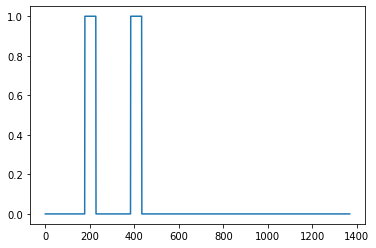

In [73]:
output_filepath = AUDIO_IGNORED_EXAMPLES_DIRECTORY + "temp.wav"
frequencies, times, x, y, inserted_points = create_training_example(silence_dict, 2, output_filepath, save=True, debug=True)
print("x: {}".format(x.shape))
print("y: {}".format(y.shape))
plt.plot(y[0])
print(inserted_points)
ipd.Audio(output_filepath)

## Dataset Generation

In [52]:
# prefix refers to the prefix naming of output audio files
def create_X_Y(size, start, mean_positives, prefix, segment, save=False, debug=False):
    i, X, Y = start, [], []
    
    for i in range(start, start + size):
        output_filepath = prefix + "_" + str(i) + ".wav"
        num_positives = int(random.gauss(mean_positives, 1))
        try:
            _, _, x, y, _ = create_training_example(silence_dict, num_positives, output_filepath, save, debug)
        except KeyError:
            print("Ran out of examples for {} positives. Please create from another audio file.".format(num_positives))
            break
        x = np.transpose(x)
        y = np.transpose(y)
        X.append(x)
        Y.append(y)
        print("Created example {}...".format(str(i)))
    return (np.array(X), np.array(Y))

In [267]:
input_filepath = BRYAN_LECTURES + "bayes_inference_processed.wav"
segment = AudioSegment.from_wav(input_filepath)
silence_dict = make_silence_dict(segment)

In [53]:
prefix = AUDIO_IGNORED_EXAMPLES_DIRECTORY + "train"
size = 1
start = 1
mean_positives = 2
X, Y = create_X_Y(size, start, mean_positives, prefix, segment, save=True, debug=True)
print("X:{} Y:{}".format(X.shape, Y.shape))
np.save(TRAINING_SET_DIRECTORY + "X_Bryan.npy", X)
np.save(TRAINING_SET_DIRECTORY + "Y_Bryan.npy", Y)

Filler added at 0.0 ms
Filler added at 1499.9837398373984 ms
Filler added at 2999.967479674797 ms
File was saved in ../audio_ignored_examples/train_1.wav
Created example 1...
X:(1, 5490, 129) Y:(1, 1369, 1)
